In [2]:
import tensorflow as tf
import numpy as np
import edward as ed
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from datetime import datetime
import pickle
import json
import seaborn as sns
from edward.models import Categorical, Dirichlet, InverseGamma, Normal, MultivariateNormalDiag, Mixture, Empirical, ParamMixture

%env THEANO_FLAGS=device=cpu,floatX=float32
import theano
import pymc3 as pm
import theano.tensor as tt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False

env: THEANO_FLAGS=device=cpu,floatX=float32


# Gaussian mixture model for image segmentation task

## Introduction

Image segmentation is a widely used technique in computer vision. It enables us to extract useful piece of information from an image by dividing it into several meaningful regions, within which pixels share similar nature. There are existing image segmentation techniques such as those based on edge detection, threshold method, Region-based method, etc [1]. In this report, we mainly focus on segmentation based on clustering and we use Gaussian mixture model with MCMC and ADVI inference. Then, we evaluate our segmentation result using both metrics and comparing against ground-truth data.  

## Dataset

Our data comes from [the Berkeley Segmentation Dataset and Benchmark](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/), which contains color image and human-labelled segmentation results.

image shape: (321, 481, 3)


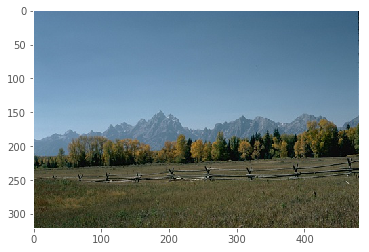

In [3]:
# Read data
train_path = "./BSR/BSDS500/data/images/train/"
img_name = "2092"
img = plt.imread(train_path+img_name+".jpg")
plt.imshow(img)
print("image shape:", img.shape)

In [4]:
# Flatten the pixel matric to 2-d array
X = img.reshape(-1, 3).astype(int)
N, D = X.shape
print("flatten pixel matrix shape:", X.shape)

flatten pixel matrix shape: (154401, 3)


## Model

A vanilla Gaussian Mixture Model (GMM) is:

$$p(\pi) = \text{Dirichlet} (\pi | \alpha \mathbf{1}_k)$$

For each cluster $k \in 1:K$:

$$p(\mu_k) = \text{Normal}(\alpha_k,\beta_k)$$

$$p(\sigma^2_k ) = \text{InverseGamma} (a,b) $$

For each data point $x_n$:

$$p(x_n | \pi, \mu, \sigma) = \sum_{i=1}^K \pi_k \text{Normal}(x_n | \mu_k, \sigma^2_k)$$

In this task, $x_n$ is 3-dimensional vector corresponding to a pixel containing RGB channels, where the value of each channel is an integer ranging from 0 to 255.


### Setting the number of clusters $K$

First, we need to specify the number of clusters $K$. A common way to select $K$ is by observing the color histogram.

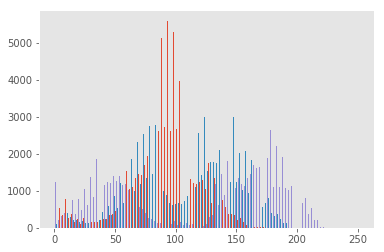

In [5]:
plt.hist(X, bins=200);

Note that the histogram is plot independently for the 3 channels, while what we want is to cluster pixels based on a combination of 3 channels. Hence it only roughly gives us a sense of how many clusters there should be.

It seems like there are 8 clusters in the color histogram.

In [19]:
K = 9

### Setting the prior

Initializing mixture models is always a challenge. In terms of the dirichlet priors for mixing probability $\pi$, $\alpha$ encodes the prior belief in the concentration of clusters. For the cluster mean $\mu_k$, we hope that it could spread over the RGB value space -- [0,255].

First, we try a shared prior for all cluster means, that is $\mu_k \sim \text{Normal}(127, 80)$, and set $\alpha=1$.

In [45]:
# Edward Model
with tf.name_scope("model"):
    pi = Dirichlet(concentration=tf.constant([1.0] * K, name="pi/weights"), name= "pi")
    mu = Normal(loc= tf.ones(D, name="centroids/loc") * 127, 
                scale= tf.ones(D, name="centroids/scale") * 80, 
                sample_shape=K, name= "centroids")
    sigma = InverseGamma(concentration=tf.ones(D, name="variability/concentration"), 
                         rate=tf.ones(D, name="variability/rate"), sample_shape=K, name= "variability")

    x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigma)},
                     MultivariateNormalDiag,
                     sample_shape=N, name= "mixture")
    z = x.cat

In [20]:
# Pymc model

# Note: You should run the model-inference-criticism loop with edward environment and pymc environment seperately.

## Set minibatch data for later training
X_shared = theano.shared(X)
minibatch_size = 500
X_minibatch = pm.Minibatch(X, minibatch_size)

with pm.Model() as model:
    pi = pm.Dirichlet('pi', np.ones(K))

    comp_dist = []
    mu = []
    sigma_sq = []
    cov = []
    for i in range(K):
        mu.append(pm.Normal('mu%i' % i, 127, 80, shape=D))
        sigma_sq.append(pm.InverseGamma('sigma_sq%i' % i, 1, 1, shape=D))

        cov.append(tt.nlinalg.alloc_diag(sigma_sq[i]))
        comp_dist.append(pm.MvNormal.dist(mu=mu[i], cov=cov[i]))

    xobs = pm.Mixture('x_obs', pi, comp_dist,
            observed=X_shared)

## Inference

### Gibbs sampling

In [213]:
T = 1000  # number of MCMC samples
with tf.name_scope("posterior"):
    qpi = Empirical(tf.get_variable(
        "qpi/params", [T, K],
        initializer=tf.constant_initializer(1.0/K)))
    qmu = Empirical(tf.get_variable(
        "qmu/params", [T, K, D],
        initializer=tf.zeros_initializer()))
    qsigma = Empirical(tf.get_variable(
        "qsigma/params", [T, K, D],
        initializer=tf.ones_initializer()))
    qz = Empirical(tf.get_variable(
        "qz/params", [T, N],
        initializer=tf.zeros_initializer(),
        dtype=tf.int32))

### ADVI

In [21]:
with model:
    advi_mf=pm.ADVI()
    %time advi_mf.fit(10000, more_replacements={X_shared: X_minibatch},obj_optimizer=pm.adagrad(learning_rate=1e-2))

Average Loss = 1.1334e+06: 100%|██████████| 10000/10000 [01:15<00:00, 131.67it/s]
Finished [100%]: Average Loss = 1.1338e+06


CPU times: user 1min 21s, sys: 9.82 s, total: 1min 31s
Wall time: 1min 29s


Plotting the loss function, where loss = - ELBO, to assess convergence:

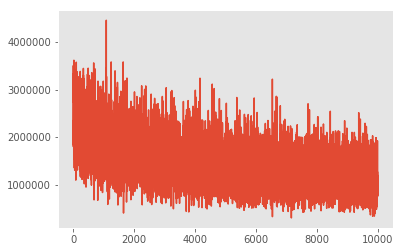

In [22]:
plt.plot(advi_mf.hist);

As we could see above, the loss is noisy, but in general, decreasing.

In [23]:
# to run for more iterations we could do
#advi_mf.refine(5000)

Now we check the segmentation results.

In [24]:
from utils import predict_cluster

In [25]:
y, point = predict_cluster(advi_mf.approx, 1000, X, model, K, cov="cov_diagonal")

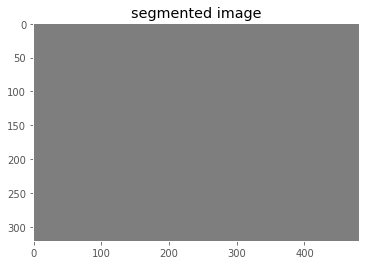

In [26]:
from utils import get_segment_img
seg_img_ADVI = get_segment_img(y, point, img)
plt.imshow(seg_img_ADVI);
plt.title("segmented image");

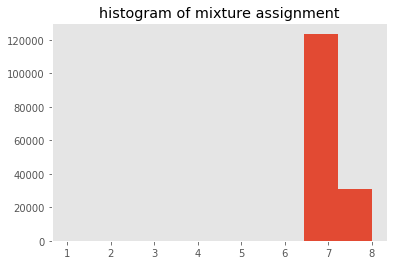

In [27]:
plt.hist(y, bins=K)
plt.title("histogram of mixture assignment");

The segmentation performance is bad with only two clusters are found. We diagnose this by plotting the posterior distribution.

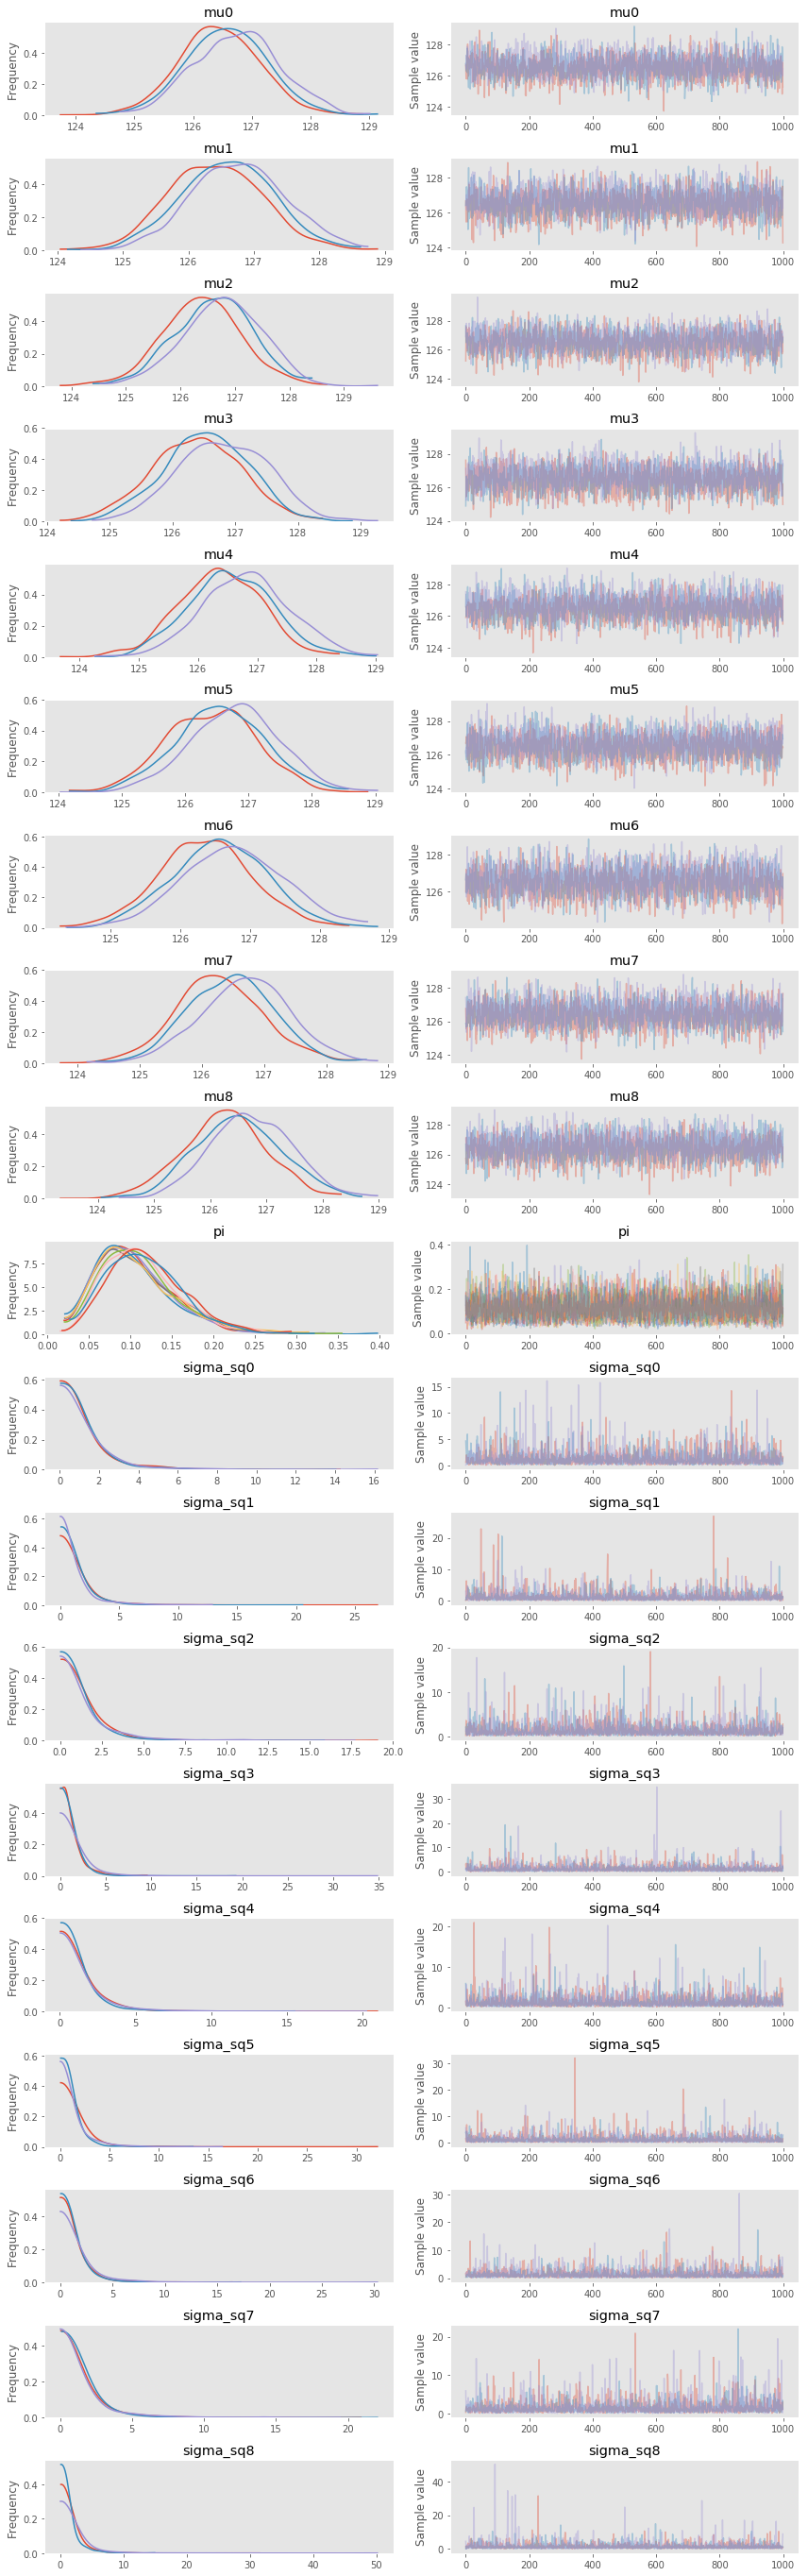

In [28]:
post_samples = advi_mf.approx.sample(1000)
pm.traceplot(post_samples);

It is shown from the plot that all $K$ cluster means have converged to roughly similar RGB values and R,G,B values are centered around 125-127, which is close to the prior mean. That is why we see grey result image.  

One possible reason is that ADVI is sensitive to the shared prior setting, hence the optimization process is stuck at a local optimum, leading to the "mode collapse".

To fix this issue for ADVI, we try a new prior, 

For $k\in 1: K$, $\mu_k \sim \text{Normal}(\alpha_k, \beta_k)$, 

where $\alpha_{k,i}$ is randomly picked from 50-200 for $i=0,1,2$, and $\beta_k$ is set to $20$. 

The intuition for the random selection, is that we hope the prior means of cluster centers could spread over RGB space, while avoiding overlapping with each other.

## Reset model

In [29]:
# pymc model
cluster_means = []

with pm.Model() as model:
    pi = pm.Dirichlet('pi', np.ones(K))

    comp_dist = []
    mu = []
    sigma_sq = []
    cov = []
    for i in range(K):
        temp_mean = np.random.randint(low=50, high=200, size=D)
        mu.append(pm.Normal('mu%i' % i, temp_mean, 20, shape=D))
        sigma_sq.append(pm.InverseGamma('sigma_sq%i' % i, 1, 1, shape=D))

        cov.append(tt.nlinalg.alloc_diag(sigma_sq[i]))
        comp_dist.append(pm.MvNormal.dist(mu=mu[i], cov=cov[i]))
        
        cluster_means.append(temp_mean)

    xobs = pm.Mixture('x_obs', pi, comp_dist,
                      observed=X_shared)

In [ ]:
# Edward model
cluster_means_tf = tf.convert_to_tensor(cluster_means, dtype=tf.float32)
with tf.name_scope("model"):
    pi = Dirichlet(concentration=tf.constant([1.0] * K, name="pi/weights"), name= "pi")
    mu = Normal(loc= cluster_means_tf, 
                scale= tf.ones(D, name="centroids/scale")*20,
                 name= "centroids")
    sigma = InverseGamma(concentration=tf.ones(D, name="variability/concentration"), 
                         rate=tf.ones(D, name="variability/rate"), sample_shape=K, name= "variability")

    x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigma)},
                     MultivariateNormalDiag,
                     sample_shape=N, name= "mixture")
    z = x.cat

## Inference

### Gibbs Sampling

### ADVI

Average Loss = 77,562: 100%|██████████| 50000/50000 [06:40<00:00, 124.87it/s]    
Finished [100%]: Average Loss = 77,563


CPU times: user 6min 23s, sys: 48.1 s, total: 7min 11s
Wall time: 6min 51s


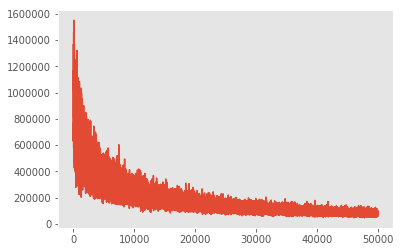

In [30]:
with model:
    advi_mf=pm.ADVI()
    %time advi_mf.fit(50000, more_replacements={X_shared: X_minibatch},obj_optimizer=pm.adagrad(learning_rate=1e-2))
    
plt.plot(advi_mf.hist)

### Segmentation results

First, we assign pixel to the cluster where it has maxmimum log likelihood. Then, for visulizing the segmentation results, we set the RGB value of each data point to be the RGB value of its assigned cluster's mean.

Hence, we could evaluate the segmentation by the contours, and the color.

In [31]:
y, point = predict_cluster(advi_mf.approx, 1000, X, model, K, cov="cov_diagonal")

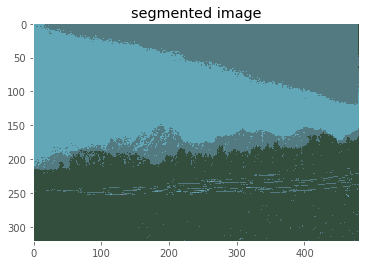

In [32]:
nrows, ncols = img.shape[0], img.shape[1]
segmented_img = np.zeros((nrows, ncols, D),dtype='int')
cluster_reshape = y.reshape(nrows, ncols)
for i in range(nrows):
    for j in range(ncols):
        cluster_number = cluster_reshape[i, j]
        segmented_img[i, j] = point['mu{0:d}'.format(cluster_number)].astype(int)
plt.imshow(segmented_img);
plt.title("segmented image");

Now, the segmentation seems fine. Let's look at the cluster histogram.

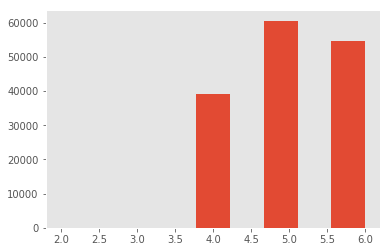

In [33]:
plt.hist(y, bins=K);

Filtering out the clusters with insignificant amount of data, approximately 6 clusters are found by ADVI.

Now, let's look at the posterior distribution.

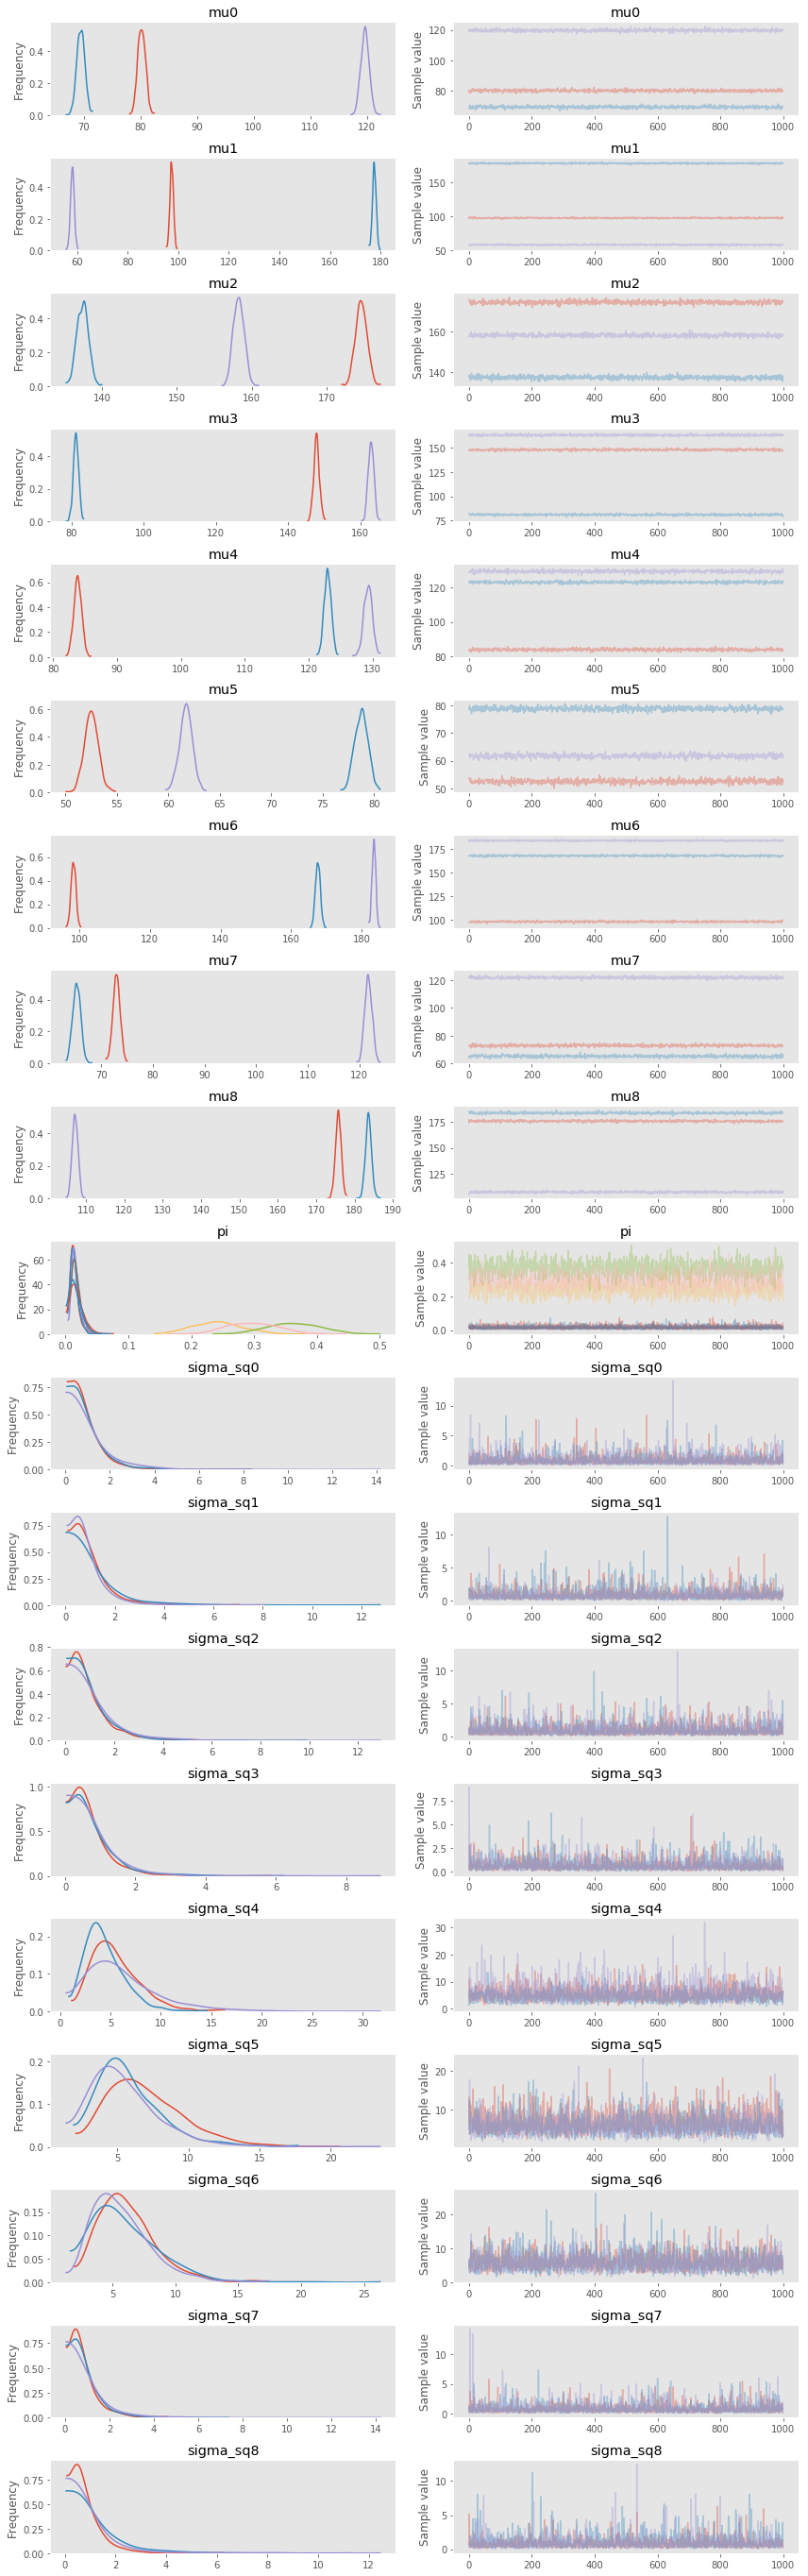

In [34]:
post_samples = advi_mf.approx.sample(1000)
pm.traceplot(post_samples);

From the posterior distribution for cluster centers $\mu_k$, we could find that 

(1) The posterior distributions are significantly different -- which identifies different clusters.
 However, it seems that $\mu_7$ and $\mu_8$ are subject to the same distribution, which means $\mu_7$ and $\mu_8$ identify overlapping cluster means. It is possible that ADVI still has a minor mode collapse problem, or, the choice of $K$ is not good: the number of clusters is less than 9.
 
(2) For each posterior distribution of cluster mean, $\mu_k$, the variance is reduced compared to the prior.

## Criticism

### 1. PSIS-diagnostic

PSIS is a method to diagnose Variatioanl Inference.

The process is:

- sample ($\theta_s, s=1:S$) from $q(\theta)$

- calculate the importance ratio $r_s = p(\theta_s, y) / q(\theta)$

- Fit generatlized pareto distribution to $M$ largest $r_s$, report the shape parameter $k$.

- If $k<0.7$, conclude VI is good; else, warn users that VI is not reliable.

In [208]:
from utils import PSIS
_, k = PSIS(advi_mf.approx, 1000)

In [209]:
k

array([inf])

Reflection:

Generally, an infinite $k$ value suggests that the posterior inference is far away from the truth posterior. However, there might be other reasons. We dig into this by comparing the value of the posterior model likelihood $p(\theta_s, y)$, and the variational distribution $q(\theta_s)$, and it turns ot that $p(\theta_s, y)$ is way less than $q(\theta_s)$. Hence, we conclude that PSIS-diagnostic performance may suffer from the scale of large dataset, and the i.i.d. data assumption.



### 2. PDI and WAPDI

$$\text{PDI}(n) = \frac{\mu (n)}{\sigma^2 (n)}  \qquad \text{PDI-log}(n) = \frac{\mu_{\log} (n)}{\sigma_{\log}^2 (n)} \qquad 
\text{WAPDI}(n) = \frac{\sigma^2_{\log}(n)}{\log \mu (n)}$$

where 
$$\mu (n) = \mathbb{E}_{\theta | x} [p(x_n | \theta) ], \qquad \mu_{\log} (n) = \mathbb{E}_{\theta | x} [\log p(x_n | \theta)], \qquad \sigma^2 (n) = \mathbb{V}_{\theta | x} [p(x_n | \theta)], \qquad \sigma^2_{\theta | x} [\log p(x_n | \theta)] . $$

In the experiments, we find that the distribution of PDI can be quite spiky, hence we also compute

$$\text{log-PDI}(n) = \log (\text{PDI} (n))$$.

Reference: [Evaluating Bayesian Models with Posterior Dispersion Indices](http://proceedings.mlr.press/v70/kucukelbir17a/kucukelbir17a.pdf)

In [182]:
from utils import PDI
pdi, pdi_log, wapdi = PDI(post_samples, model)
log_pdi = np.log(pdi)

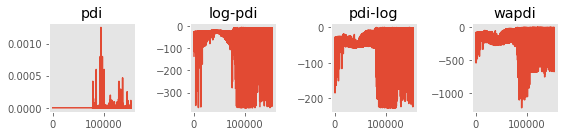

In [163]:
fig, axs = plt.subplots(1,4, figsize=(8,2))
axs[0].plot(pdi)
axs[0].set_title("pdi")
axs[1].plot(log_pdi)
axs[1].set_title("log-pdi")
axs[2].plot(pdi_log)
axs[2].set_title("pdi-log")
axs[3].plot(wapdi)
axs[3].set_title("wapdi")
plt.tight_layout()

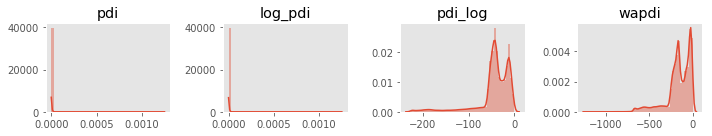

In [207]:
fig, axs = plt.subplots(1,4, figsize=(10,2))
sns.distplot(pdi[np.isfinite(pdi)], ax=axs[0])
axs[0].set_title("pdi")
sns.distplot(pdi[np.isfinite(log_pdi)], ax=axs[1])
axs[1].set_title("log_pdi")
sns.distplot(pdi_log, ax=axs[2])
axs[2].set_title("pdi_log")
sns.distplot(wapdi, ax=axs[3])
axs[3].set_title("wapdi")
plt.tight_layout()

### 3. Image segmentation criteria

In this section, we will compare the MCMC/ADVI-segmented results with human-segmented results, which is referred as "ground truth".

We use the follow criteria to compare the segmented image to the "ground truth".

- Homogeneity score:
  - A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
  - Asymmetric.
  
- completeness score
  - A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
  - Asymmetric.

- v_measure score
  - The harmonic mean between homogeneity and completeness
  
- adjusted rand score
  - A similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
  - Symmetric
  
- adjusted mutual info score
  - Can be useful to measure the agreement of two independent label assignments strategies on the same dataset when the real ground truth is not known.
  - Symmetric


In [125]:
from scipy.io import loadmat
from sklearn import metrics

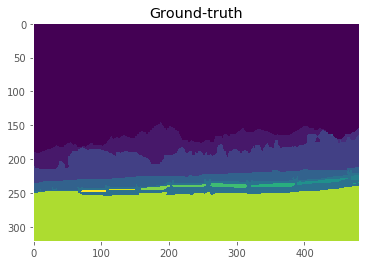

In [132]:
# importing ground truth
truth_path = "./BSR/BSDS500/data/groundTruth/train/"
gt = loadmat(truth_path+img_name+".mat") 
gt0 = gt['groundTruth'][0][0]
val0 = gt0[0,0][0].astype('int64')
plt.imshow(val0)
plt.title("Ground-truth");

In [134]:
labels_true = val0.flatten()
labels = y

In [135]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))

Homogeneity: 0.487
Completeness: 0.441
V-measure: 0.463
Adjusted Rand Index: 0.360
Adjusted Mutual Information: 0.441


/Users/leah/Columbia/courses/ml_prob_programming/ENV/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


## Intrepreting PDI and WAPDI

segmenting more images...

## Discussion